In [1]:
!pip install -qU datasets transformers accelerate timm albumentations>=1.4.5 torchmetrics pycocotools

# Object Detection

**Object detection** is the computer vision task of detecting instances in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated labels of the detected objects.

An image can contain multiple objects, each with its own bounding box and a label, and each object can be present in different parts of an image.

We will finetune **DETR** (combining a convolutional backbone with an encoder-decoder Transformer) on the **CPPE-5**.

In [2]:
# constants
MODEL_NAME = 'microsoft/conditional-detr-resnet-50'
IMAGE_SIZE = 480

## Load the CPPE-5 dataset

The **CPPE-5** dataset contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

In [4]:
from datasets import load_dataset

cppe5 = load_dataset('cppe-5')

if 'validation' not in cppe5:
    split = cppe5['train'].train_test_split(0.15, seed=1111)
    cppe5['train'] = split['train']
    cppe5['validation'] = split['test']

README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

In [5]:
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

In [6]:
cppe5['train'][0]

{'image_id': 205,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x667>,
 'width': 1200,
 'height': 667,
 'objects': {'id': [1327, 1328, 1329, 1330, 1331, 1332],
  'area': [8190, 1386, 1900, 1728, 3520, 145145],
  'bbox': [[813.0, 119.0, 78.0, 105.0],
   [406.0, 232.0, 42.0, 33.0],
   [480.0, 339.0, 50.0, 38.0],
   [474.0, 235.0, 48.0, 36.0],
   [805.0, 88.0, 80.0, 44.0],
   [757.0, 46.0, 319.0, 455.0]],
  'category': [4, 4, 4, 4, 3, 0]}}

* `image_id`: the example image id
* `image`: a `PIL.Image.Image` object containing the image
* `width`: width of the image
* `height`: height of the image
* `objects`: a dictionary containing bounding box metadata for the objects in the image:
  * `id`: the annotation id
  * `area`: the area of the bounding box
  * `bbox`: the object's bounding box (in the COCO format)
  * `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)`, and `Mask (4)`


The `bbox` field follows the COCO format, which is the format that the DETR model expects.

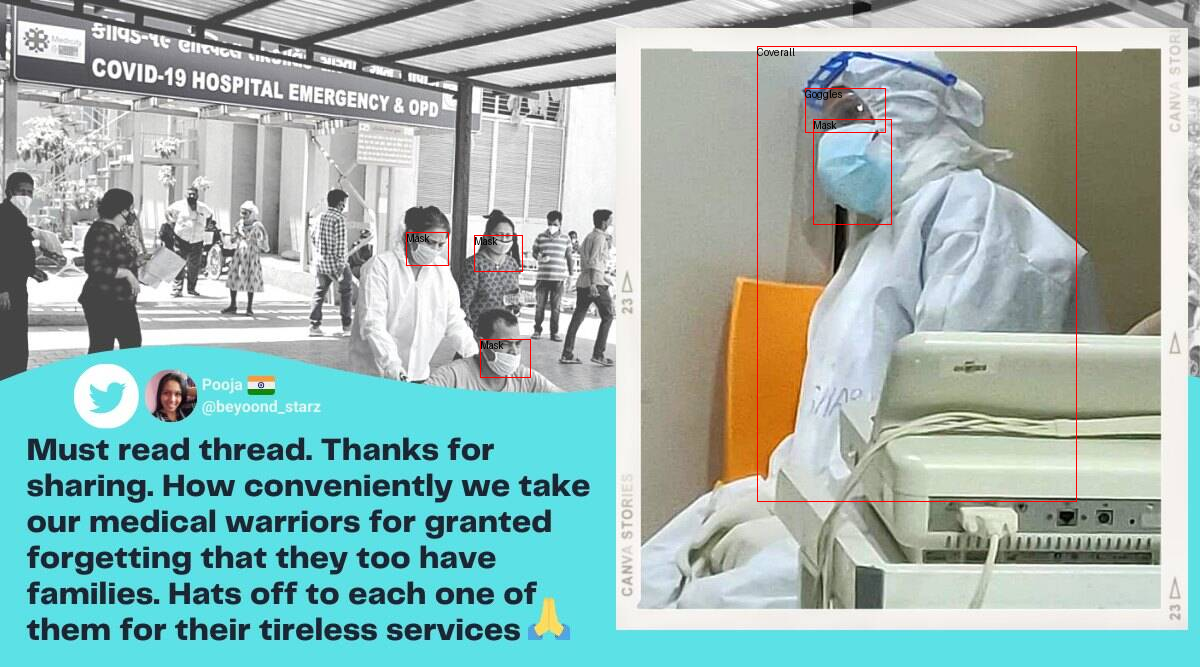

In [9]:
import numpy as np
import os
from PIL import Image, ImageDraw

sample = cppe5['train'][0]
image = sample['image']
annotations = sample['objects']
draw = ImageDraw.Draw(image)

categories = cppe5['train'].features['objects'].feature['category'].names
id2label = {idx: x for idx, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations['id'])):
    box = annotations['bbox'][i]
    class_idx = annotations['category'][i]
    x, y, w, h = tuple(box)

    # check if coordinates are normalized
    if max(box) > 1.0:
        # coordinates are unnormalized, no need to rescale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # coordinates are normalized, rescale them
        x1 = int(x * sample['width'])
        y1 = int(y * sample['height'])
        x2 = int((x + w) * sample['width'])
        y2 = int((y + h) * sample['height'])

    draw.rectangle(
        (x1, y1, x2, y2),
        outline='red',
        width=1
    )
    draw.text(
        (x1, y1),
        id2label[class_idx],
        fill='black'
    )

image

Note that in the bounding boxes above, we assume that they are in `COCO` format `(x_min, y_min, width, height)`, so we need to adjust them to work with other format like `(x_min, y_min, x_max, y_max)`.

One common issue with object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise errors during training and should be addressed. To keep things simple in this guide, we will set `clip=True` for `BboxParams` in transformations below.

## Preprocess the data

We will use the `AutoImageProcessor` to preprocess the data so to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor also has some attributes:
* `image_mean = [0.485, 0.456, 0.406]`
* `image_std = [0.229, 0.224, 0.225]`

These are used to normalize images during the model pretraining.

In [10]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={'max_height': MAX_SIZE, 'max_width': MAX_SIZE},
    do_pad=True,
    pad_size={'height': MAX_SIZE, 'width': MAX_SIZE},
)

preprocessor_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
image_processor

ConditionalDetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConditionalDetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 480,
    "width": 480
  },
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "max_height": 480,
    "max_width": 480
  }
}

Before passing the images to the `image_processor`, we will apply two preprocessing transformations to the dataset using **Albumentations**. This library ensures the transformations affect the image and update the bounding boxes accordingly.

In [12]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1)
    ],
    bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category'],
        clip=True,
        min_area=25
    )
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category'],
        clip=True
    )
)

The `image_processor` expects the annotations to be in the following fomrat: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a COCO object annotation. We will add a function to reformat annotations for a single example:

In [13]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Parameters
    ----------
    image_id: str
        image id, e.g., "0001"
    categories: List[str]
        list of categories/class labels corresponding to provided bounding boxes
    areas: List[float]
        list of areas corresponding to provided bounding boxes
    bboxes: List[Tuple[float]]
        list of bounding boxes provided in COCO format
        ([center_x, center_y, width, height] in absolute coordinates)

    Returns
    -------
    Dict
        {'image_id': image id,
         'annotations': list of formatted annotations}
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            'image_id': image_id,
            'category_id': category,
            'iscrowd': 0,
            'area': area,
            'bbox': list(bbox)
        }
        annotations.append(formatted_annotation)

    return {
        'image_id': image_id,
        'annotations': annotations
    }

Now we can combine the image and annotation transformations:

In [19]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    images = []
    annotations = []

    for image_id, image, objects in zip(examples['image_id'], examples['image'], examples['objects']):
        image = np.array(image.convert('RGB'))

        # augmentation
        output = transform(
            image=image,
            bboxes=objects['bbox'],
            category=objects['category']
        )
        images.append(output['image'])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id,
            output['category'],
            objects['area'],
            output['bboxes']
        )
        annotations.append(formatted_annotations)

    # apply image processor transformations
    result = image_processor(
        images=images,
        annotations=annotations,
        return_tensors='pt'
    )

    if not return_pixel_mask:
        result.pop('pixel_mask', None)

    return result

We can apply this preprocessing function to the entire dataset using `with_transform` method.

In [20]:
from functools import partial

train_transform_batch = partial(
    augment_and_transform_batch,
    transform=train_augment_and_transform,
    image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch,
    transform=validation_transform,
    image_processor=image_processor
)

cppe5['train'] = cppe5['train'].with_transform(train_transform_batch)
cppe5['validation'] = cppe5['validation'].with_transform(validation_transform_batch)
cppe5['test'] = cppe5['test'].with_transform(validation_transform_batch)

In [21]:
cppe5['train'][0]

{'pixel_values': tensor([[[-0.8678, -0.9705, -1.0562,  ...,  0.1597,  0.0569,  0.1426],
          [ 0.1768, -0.0287, -0.1828,  ...,  0.1597,  0.2624,  0.2796],
          [ 0.2624,  0.2796,  0.6734,  ...,  0.2796,  0.2111,  0.5707],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.7577, -0.8627, -0.9503,  ...,  0.2927,  0.1877,  0.2752],
          [ 0.3102,  0.1001, -0.0574,  ...,  0.2927,  0.3978,  0.4153],
          [ 0.3978,  0.4153,  0.8179,  ...,  0.4153,  0.3452,  0.7129],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.4798, -0.6018, -0.6715,  ...,  0.5136,  0.4091,  0.4962],
          [ 

Within each example, we should see a tensor with `pixel_values`, a tensor with `pixel_mask`, and `labels`.


Preprocessing is not complete yet. We still need to create a custom `collate_fn` to batch iamges together. Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1) and which are padding (0).

In [22]:
import torch

def collate_fn(batch):
    data = {}
    data['pixel_values'] = torch.stack(
        [x['pixel_values'] for x in batch]
    )
    data['labels'] = [x['labels'] for x in batch]

    if 'pixel_mask' in batch[0]:
        data['pixel_mask'] = torch.stack(
            [x['pixel_mask'] for x in batch]
        )

    return data

## Preparing function to compute mAP

Object detection models are commonly evaluated with a set of **COCO-style metrics**. We will use `torchmetrics` to compute `mAP` (mean average precision) and `mAR` (mean average recall) metrics and will wrap it to `compute_metrics` function in order to use in `Trainer` for evaluation.

Intermediate format of boxes used for training is `YOLO` (normalized) but we will compute metrics for boxes in `Pascal VOC` (absolute) format in order to correctly handle box areas.

In [23]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """Convert bounding boxes from YOLO format (center_x, center_y, width, height)
    in range [0, 1] to Pascal VOC foramt (x_min, y_min, x_max, y_max) in absolute coordinates

    Parameters
    ----------
    boxes: torch.Tensor
        bounding boxes in YOLO format
    image_size: Tuple[int, int]
        image size in format (height, width)

    Returns
    -------
    torch.Tensor
        bounding boxes in Pascal VOC format
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In `compute_metrics` function, we collect `predicted` and `target` bounding boxes, scores and labels from evaluation loop results and pass it to the scoring function.

In [24]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """Compute mAP, mAR and their variants for the object detection task

    Parameters
    ----------
    evaluation_results: EvalPrediction
        predictions and target from evaluation
    image_processor: ConditionalDetrImageProcessor
        preprocessing image processor
    threshold: float
        threshold to filter predicted boxes by confidence. Default to 0.0
    id2label: Optional[Dict]
        mapping from class id to class name. Default to None

    Returns
    -------
    Mapping[str, float]
        metrics in a form of dictionary {<metric_name>: <metric_value>}
    """
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation,
    # - targets in a form of list of dictionaries with keys "boxes", "labels"
    # - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    postprocessed_targets = []
    postprocessed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes
        batch_image_sizes = torch.tensor(np.array([x['orig_size'] for x in batch]))
        image_sizes.append(batch_image_sizes)

        # collect boxes that were converted to YOLO format needed for model training
        # We will convert them to Pascal VOC format
        for image_target in batch:
            boxes = torch.tensor(image_target['boxes'])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target['orig_size'])
            labels = torch.tensor(image_target['class_labels'])
            postprocessed_targets.append({'boxes': boxes, 'labels': labels})

    # Collect predictions in the required format for metric computation
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(
            logits=torch.tensor(batch_logits),
            pred_boxes=torch.tensor(batch_boxes)
        )
        # model produces boxes in YOLO format, then
        # image_processor converts them to Pascal VOC format
        postprocessed_output = image_processor.post_process_object_detection(
            output,
            threshold=threshold,
            target_sizes=target_sizes
        )
        postprocessed_predictions.extend(postprocessed_output)


    # Compute metrics
    metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
    metric.update(postprocessed_predictions, postprocessed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop('classes')
    map_per_class = metrics.pop('map_per_class')
    mar_100_per_class = metrics.pop('mar_100_per_class')

    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f'map_{class_name}'] = class_map
        metrics[f'mar_100_{class_name}'] = class_mar


    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics

In [25]:
eval_compute_metrics_fn = partial(
    compute_metrics,
    image_processor=image_processor,
    id2label=id2label,
    threshold=0.0
)

## Training the detection model

When loading the model from the same checkpoint that we used for the preprocessing, we need to pass the `label2id` and `id2label` maps that we created earlier from the dataset's metadata. In addition, we also specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [26]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--conditional-detr-resnet-50/snapshots/8f8795fb7c319c7862d4f4cd699e76bb09cf2593/config.json
Model config ConditionalDetrConfig {
  "_name_or_path": "microsoft/conditional-detr-resnet-50",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "ConditionalDETRForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 2,
  "cls_loss_coefficient": 2,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layer

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--microsoft--conditional-detr-resnet-50/snapshots/8f8795fb7c319c7862d4f4cd699e76bb09cf2593/model.safetensors


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/conditional-detr-resnet-50 were not used when initializing ConditionalDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing ConditionalDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConditionalDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ConditionalDetrForObje

In the `TrainingArguments`, We do NOT remove unused columns because this will drop he image column so we set `remove_unused_columns=False`. We also set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated, we will not be able to determine which boxes belongs to particular image.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr_finetuned_cppe5",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=False,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe5["train"],
    eval_dataset=cppe5["validation"],
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

## Evaluate

In [ ]:
from pprint import pprint

metrics = trainer.evaluate(
    eval_dataset=cppe5['test'],
    metric_key_prefix='test'
)
print(metrics)

## Inference

In [ ]:
import torch
import requests
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
model_repo = "qubvel-hf/detr_finetuned_cppe5"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

In [ ]:
# detect bounding boxes
with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(
        outputs,
        threshold=0.3,
        target_sizes=target_sizes
    )[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [ ]:
# check the result
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image